In [1]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
from jax.scipy.stats import norm,uniform,binom,poisson,nbinom
from numpy.random import default_rng
import numpy as np
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import equinox as eqx



In [2]:
beta = 0.4
eta = 1/7
gamma = 1/14 #0.07
q=0.1
mu = 0.01
t_vec = jnp.linspace(0,100,100)

def SEIR(t,y,args):
  beta,eta,gamma,q,mu = args
  S,E,I,R = y
  N = S+E+I+R

  dS = - beta * ((E + q * I)/N) * S
  dE = beta * ((E + q * I)/N) * S - eta*E - gamma * E
  dI = eta * E - gamma * I - mu * I
  dR = gamma * E + gamma * I


  return jnp.array([dS,dE,dI,dR])

In [3]:
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(SEIR),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=t_vec)
        )
  return solution.ys

rng_key = jax.random.PRNGKey(0)

y_true = model(t_vec,jnp.array([1000,1.,1.,0]),(beta,eta,gamma,q,mu))

rng = default_rng(1)

data_newI = rng.poisson(eta * y_true[:,1] + 0.005)

data_newD = rng.poisson(mu * y_true[:,2] + 0.005)


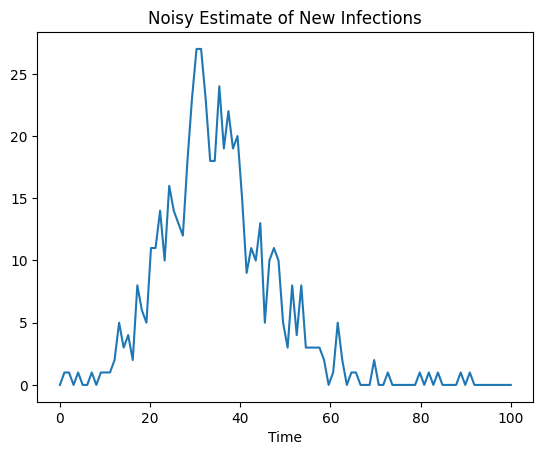

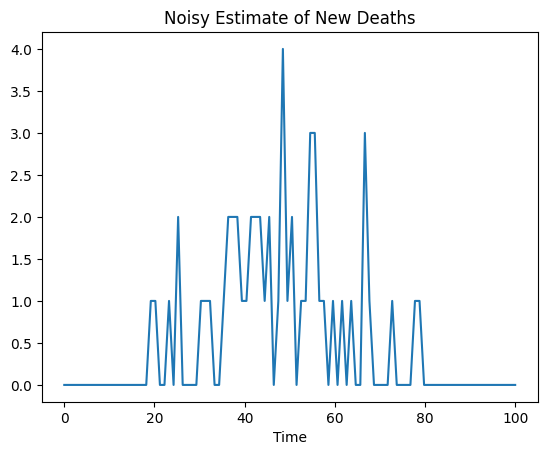

In [4]:
plt.title('Noisy Estimate of New Infections')
plt.plot(t_vec,data_newI)
plt.xlabel('Time')
plt.show()

plt.title('Noisy Estimate of New Deaths')
plt.xlabel('Time')
plt.plot(t_vec,data_newD)
plt.show()

In [5]:
def log_likelihood(par):
  beta,eta,gamma,q,mu = par
  model_output = model(t_vec,jnp.array([1000.,1.,1.,0.]),(beta,eta,gamma,q,mu))
  return jnp.sum(poisson.logpmf(data_newI, eta * model_output[:,1]) + poisson.logpmf(data_newD,mu * model_output[:,2]))

In [6]:

def hmc(n_samples, x_init, n_steps, step_size,key):
    """Run Hamiltonian Monte Carlo to draw `n_samples` from the log density
    `logp`, starting at initial state `x0`.
    """
    r_scale = 1.
    # Kinetic and potential energy functions.
    T = lambda r: -norm.logpdf(r,scale = r_scale).sum()

    V = lambda x: -log_likelihood(x)

    grad_V = jax.jit(jax.grad(V))

    acc_record = jnp.zeros((n_samples,))

    dim = len(x_init)
    samples = jnp.zeros((n_samples, dim))
    samples = samples.at[0,:].set(x_init)

    for iter in range(1, n_samples):

        if(iter % 100 == 0):
             #print the acceptance rate and likelihood every 10 iterations
          print(f"iteration: {iter} | Acceptance rate: {jnp.sum(acc_record[:iter])/iter} | param vec: {samples[iter-1,:]}")

        x_curr = samples[iter-1,:]
        key, key_r = jax.random.split(key)
        r_curr = r_scale * jax.random.normal(key = key_r, shape=(dim,))

        x_prop, r_prop = x_curr, r_curr
        for _ in range(n_steps):
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)
            x_prop = x_prop + step_size * r_prop
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)


        H_prop = T(r_prop) + V(x_prop)
        H_curr = T(r_curr) + V(x_curr)
        alpha  = jnp.exp(-H_prop + H_curr)

        key, accept_key = jax.random.split(key)
        if jax.random.uniform(minval = 0, maxval = 1, key = accept_key) < alpha:
            x_curr = x_prop
            acc_record = acc_record.at[iter].set(1)

        samples = samples.at[iter,:].set(x_curr)

    return samples



In [7]:
key = jax.random.PRNGKey(0)
key, init_key = jax.random.split(key)
key, hmc_key = jax.random.split(key)

samples = hmc(
    n_samples=5_000,
    x_init=jnp.array([0.1,0.1,0.1,0.1,0.1]),#beta,eta,gamma,q,mu
    n_steps=10,
    step_size=0.0001,
    key = hmc_key
)

iteration: 100 | Acceptance rate: 0.9900000095367432 | param vec: [0.34018278 0.04910097 0.06271002 0.09593458 0.03207272]
iteration: 200 | Acceptance rate: 0.9950000047683716 | param vec: [0.36007875 0.07074104 0.06523033 0.09965862 0.00771254]
iteration: 300 | Acceptance rate: 0.996666669845581 | param vec: [0.3749383  0.09104789 0.05810169 0.08444972 0.00672169]
iteration: 400 | Acceptance rate: 0.9975000023841858 | param vec: [0.38790184 0.0940953  0.07421459 0.07625798 0.00641223]
iteration: 500 | Acceptance rate: 0.9980000257492065 | param vec: [0.38522476 0.0996106  0.07188171 0.07373881 0.00826747]
iteration: 600 | Acceptance rate: 0.9983333349227905 | param vec: [0.38367763 0.09863144 0.06884705 0.0683179  0.00806392]
iteration: 700 | Acceptance rate: 0.9985714554786682 | param vec: [0.37780872 0.08858744 0.05619409 0.0528073  0.00833175]
iteration: 800 | Acceptance rate: 0.9987499713897705 | param vec: [0.37299597 0.07776859 0.05629246 0.05985986 0.00794853]
iteration: 900 | 

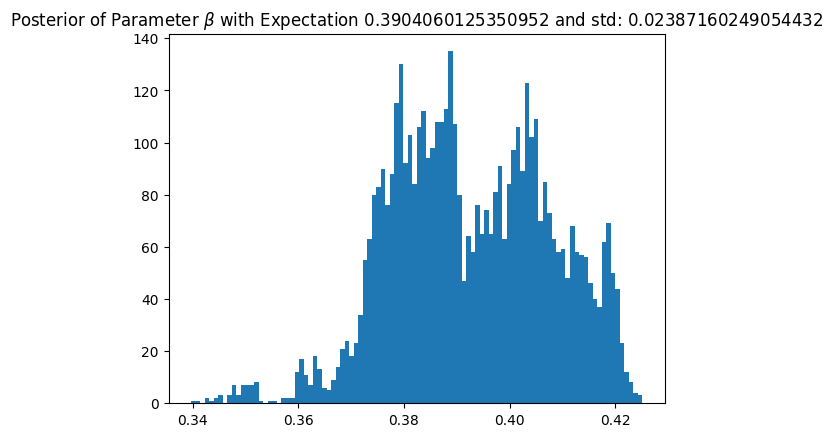

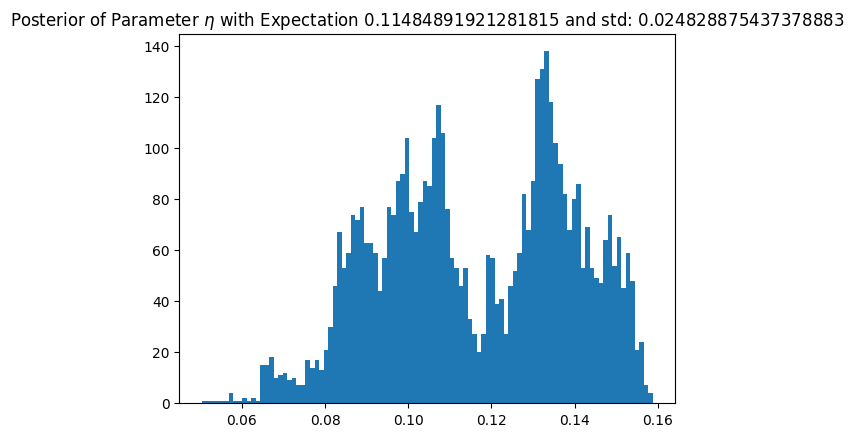

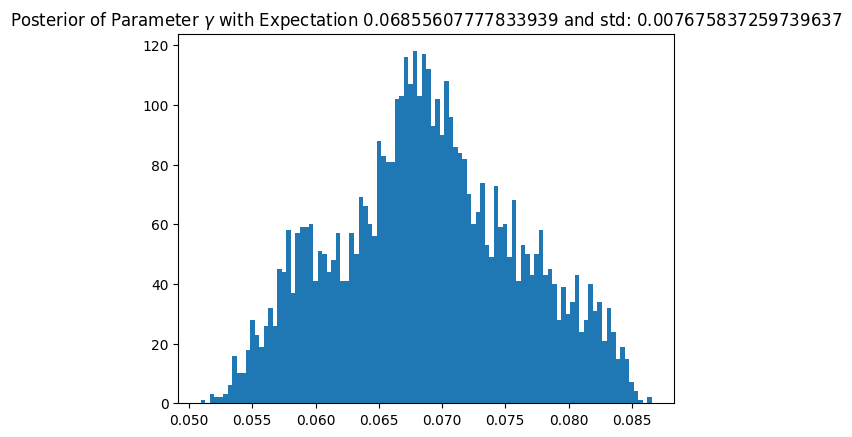

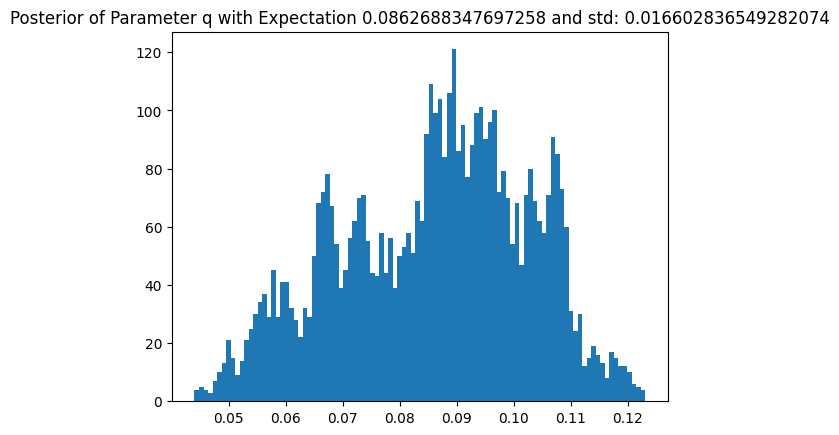

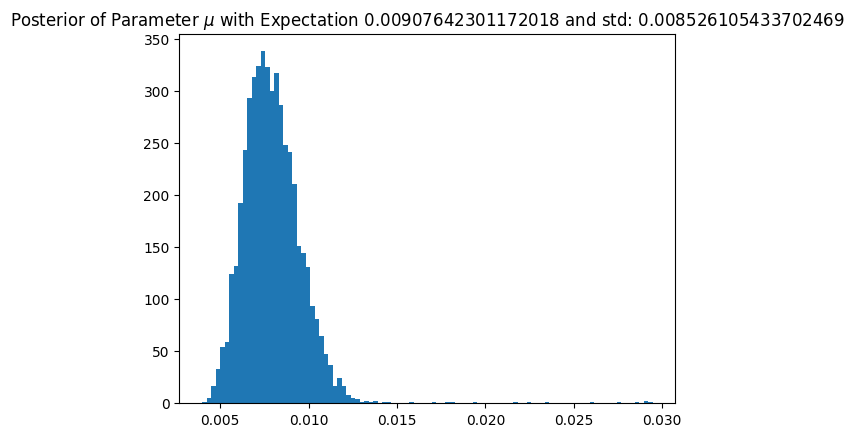

In [8]:
burn_in = 100
plt.title(f"Posterior of Parameter $\\beta$ with Expectation {jnp.mean(samples[:,0])} and std: {jnp.std(samples[:,0])}")
plt.hist(samples[burn_in:,0],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\eta$ with Expectation {jnp.mean(samples[:,1])} and std: {jnp.std(samples[:,1])}")
plt.hist(samples[burn_in:,1],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\gamma$ with Expectation {jnp.mean(samples[:,2])} and std: {jnp.std(samples[:,2])}")
plt.hist(samples[burn_in:,2],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter q with Expectation {jnp.mean(samples[:,3])} and std: {jnp.std(samples[:,3])}")
plt.hist(samples[burn_in:,3],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\mu$ with Expectation {jnp.mean(samples[:,4])} and std: {jnp.std(samples[:,4])}")
plt.hist(samples[burn_in:,4],bins = 100)
plt.show()


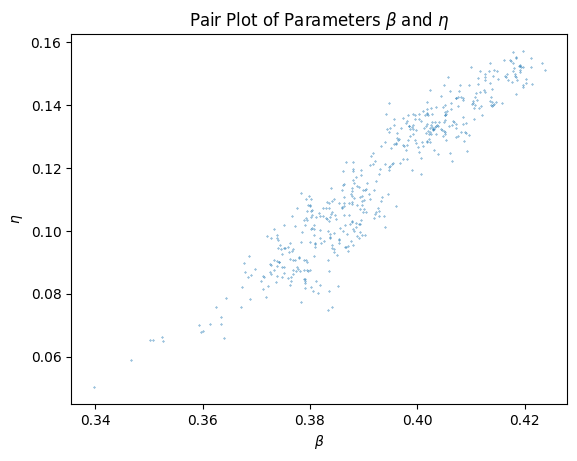

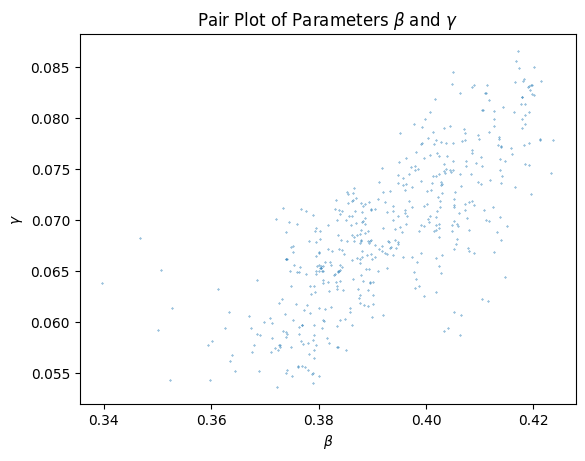

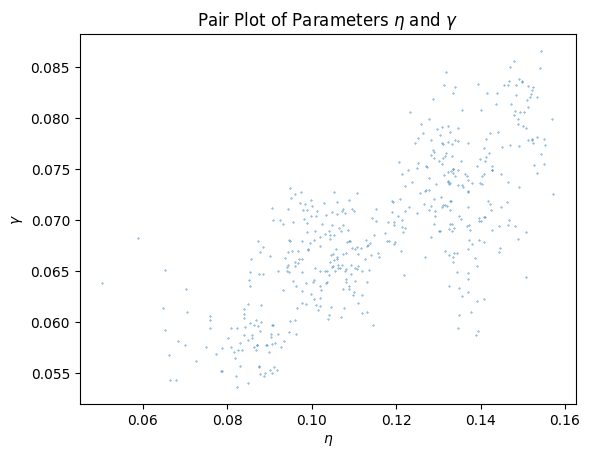

In [9]:
plt.title("Pair Plot of Parameters $\\beta$ and $\\eta$")
plt.xlabel('$\\beta$')
plt.ylabel('$\\eta$')
plt.scatter(samples[burn_in::10,0],samples[burn_in::10,1],s=0.1)
plt.show()

plt.title("Pair Plot of Parameters $\\beta$ and $\\gamma$")
plt.xlabel('$\\beta$')
plt.ylabel('$\\gamma$')
plt.scatter(samples[burn_in::10,0],samples[burn_in::10,2],s=0.1)
plt.show()

plt.title("Pair Plot of Parameters $\\eta$ and $\\gamma$")
plt.xlabel('$\\eta$')
plt.ylabel('$\\gamma$')
plt.scatter(samples[burn_in::10,1],samples[burn_in::10,2],s=0.1)
plt.show()